In [1]:
import numpy as np
import mujoco
import os
from ament_index_python.packages import get_package_share_directory

from mjx_planner import cem_planner
from quat_math import quaternion_distance, quaternion_multiply, rotation_quaternion
# from sampling_based_planner.Simple_MLP.mlp_singledof import MLP, MLPProjectionFilter


In [2]:
# model_path = os.path.join(get_package_share_directory('real_demo'), 'panda_mjx', 'franka_emika_panda', 'panda_scene.xml')

print(os.getcwd())


/home/alinjar/colcon_ws/manipulator_mujoco/real_demo/sampling_based_planner


In [3]:
# model_path = "../panda_mjx/franka_emika_panda/panda_scene.xml"
model_path = "../ur5e_hande_mjx/scene.xml"
num_dof = 12
num_batch = 100
num_steps = 12
maxiter_cem = 1
num_elite = 0.05
timestep = 0.1
maxiter_projection = 5
max_joint_pos = 180.0*np.pi/180.0
max_joint_vel=1.0
max_joint_acc = 2.0
max_joint_jerk=4.0

model = mujoco.MjModel.from_xml_path(model_path)
cem = cem_planner(
            model=model,
            num_dof=num_dof, 
            num_batch=num_batch, 
            num_steps=num_steps, 
            maxiter_cem=maxiter_cem,
            num_elite=num_elite,
            timestep=timestep,
            maxiter_projection=maxiter_projection,
            max_joint_pos=max_joint_pos,
            max_joint_vel=max_joint_vel,
            max_joint_acc=max_joint_acc,
            max_joint_jerk=max_joint_jerk,

        )


Found geom: id=8, name='robot_1'
Found geom: id=13, name='robot_2'
Found geom: id=14, name='robot_3'
Found geom: id=19, name='robot_4'
Found geom: id=20, name='robot_5'
Found geom: id=24, name='robot_6'
Found geom: id=28, name='robot_7'
Found geom: id=29, name='robot_8'
Found geom: id=33, name='robot_0'
Found geom: id=35, name='robot_01'
Found geom: id=37, name='robot_02'
Found geom: id=44, name='robot_11'
Found geom: id=49, name='robot_12'
Found geom: id=50, name='robot_13'
Found geom: id=55, name='robot_14'
Found geom: id=56, name='robot_15'
Found geom: id=60, name='robot_16'
Found geom: id=64, name='robot_17'
Found geom: id=65, name='robot_18'
Found geom: id=68, name='robot_10'
Found geom: id=71, name='robot_101'
Found geom: id=75, name='robot_103'
Found geom: id=79, name='robot_102'
Found geom: id=83, name='robot_104'
(174,)
(12, 174)

 Default backend: gpu
 Timestep: 0.1 
 CEM Iter: 1 
 Projection Iter: 5 
 Number of batches: 100 
 Number of steps per trajectory: 12 
 Time per tra

In [4]:
# import jax
# def compute_xi_samples(self, key, xi_mean, xi_cov ):
#     key, subkey = jax.random.split(key)
#     xi_samples = jax.random.multivariate_normal(key, xi_mean, xi_cov+0.003*jnp.identity(self.nvar), (self.num_batch, ))
#     return xi_samples, key

import jax
import jax.numpy as jnp

In [5]:
# cost, best_cost_list, thetadot_horizon, theta_horizon, xi_mean, xi_cov, thd_all, th_all, avg_primal_res, avg_fixed_res, \
# primal_res, fixed_res, idx_min, ball_out, eef_0_planned, eef_1_planned = cem.compute_cem(
#             xi_mean,
#             xi_cov,
#             current_pos,
#             current_vel,
#             np.zeros(num_dof),  # Zero initial acceleration
#             target_0,
#             target_2,
#             ball_pick_init,
#             lamda_init,
#             s_init,
#             xi_samples,
#             cost_weights,
#         )

In [6]:
xi_mean_single = jnp.zeros(cem.nvar_single)
xi_cov_single = 10*jnp.identity(cem.nvar_single)
xi_mean = jnp.tile(xi_mean_single, cem.num_dof)
xi_cov = jnp.kron(jnp.eye(cem.num_dof), xi_cov_single)
key = jax.random.PRNGKey(42)
xi_samples, _ = cem.compute_xi_samples(key, xi_mean, xi_cov)

init_pos = jnp.array([0.0, -0.3, 0.0, -2.0, 0.0, 1.7,
                      0.0, -0.3, 0.0, -2.0, 0.0, 1.7])

init_vel = jnp.array([0.1, 0.2, 0.05, -0.05, 0.01, 0.05,
                      0.0, 0.1, 0.04, 0.07, 0.03, 0.1])

thetadot_init = jnp.tile(init_vel, (cem.num_batch, 1))

state_term = thetadot_init	

lamda_init = jnp.zeros((cem.num_batch, cem.nvar))
s_init = jnp.zeros((cem.num_batch, cem.num_total_constraints))

# xi_filtered, primal_residuals, fixed_point_residuals = cem.compute_projection(
#                                                                     xi_samples, 
#                                                                     state_term, 
#                                                                     lamda_init, 
#                                                                     s_init, 
#                                                                     init_pos)

xi_samples_reshaped = xi_samples.reshape(num_batch, num_dof, num_steps)
xi_samples_batched_over_dof = jnp.transpose(xi_samples_reshaped, (1, 0, 2)) # shape: (DoF, B, num)

state_term_reshaped = state_term.reshape(num_batch, num_dof, 1)
state_term_batched_over_dof = jnp.transpose(state_term_reshaped, (1, 0, 2)) #Shape: (DoF, B, 1)

lamda_init_reshaped = lamda_init.reshape(num_batch, num_dof, num_steps)
lamda_init_batched_over_dof = jnp.transpose(lamda_init_reshaped, (1, 0, 2)) # shape: (DoF, B, num)

s_init_reshaped = s_init.reshape(num_batch, num_dof, cem.num_total_constraints_per_dof )
s_init_batched_over_dof = jnp.transpose(s_init_reshaped, (1, 0, 2)) # shape: (DoF, B, num_total_constraints_per_dof)



# Pass all arguments as positional arguments; not keyword arguments
xi_filtered, primal_residuals, fixed_point_residuals = cem.compute_projection_batched_over_dof(
                                                            xi_samples_batched_over_dof, 
                                                            state_term_batched_over_dof, 
                                                            lamda_init_batched_over_dof, 
                                                            s_init_batched_over_dof, 
                                                            init_pos)

xi_filtered = xi_filtered.transpose(1, 0, 2).reshape(cem.num_batch, -1) # shape: (B, num*num_dof)

In [7]:
print(primal_residuals.shape)
print(fixed_point_residuals.shape)

(12, 5, 100)
(12, 5, 100)


In [8]:
primal_residuals = jnp.linalg.norm(primal_residuals, axis = 0)
fixed_point_residuals = jnp.linalg.norm(fixed_point_residuals, axis = 0)

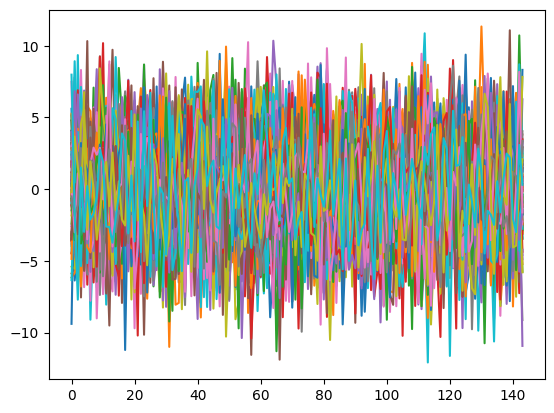

In [9]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(xi_samples.T)
plt.show()

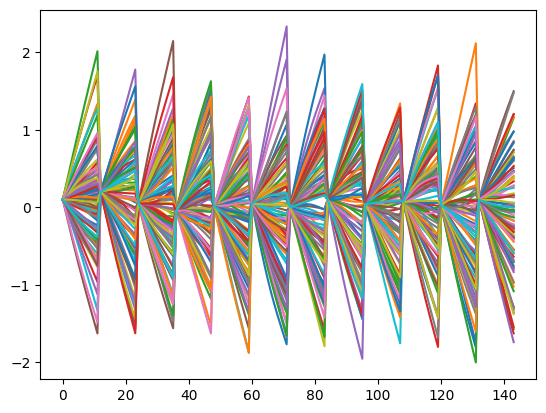

In [10]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(xi_filtered.T)
plt.show()

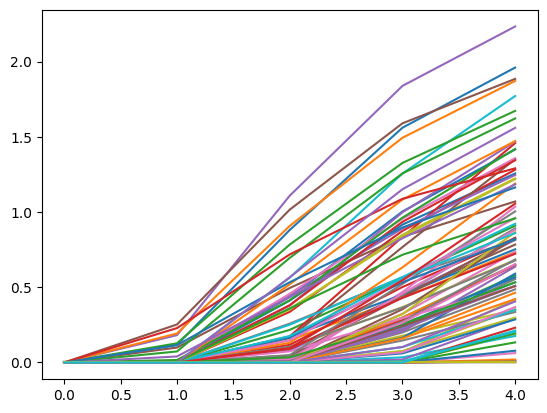

In [11]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(primal_residuals)
plt.show()

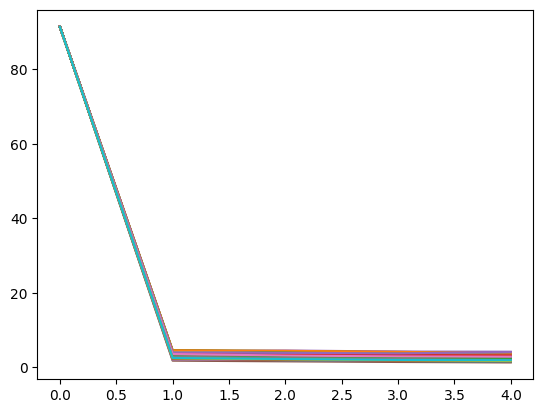

In [12]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fixed_point_residuals)
plt.show()